In [272]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import pyroomacoustics as pra
import pickle as pkl
import pandas as pd
from scipy.io import wavfile
from scipy.signal import fftconvolve
from scipy import signal
from matplotlib import gridspec


## Room creation

0.024165


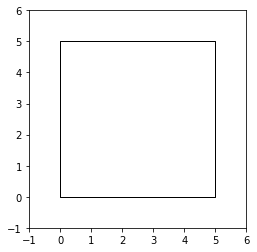

In [166]:
corners = np.array([[0,0],[0,5],[5,5],[5,0]]).T
room = pra.Room.from_corners(corners)
#room.extrude(3.0)
fig,ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 6])
#ax.set_zlim([0, 5]);
RT60 = 0.3
room_eadge = 3.
room_height = 3.
V = (room_eadge**2)*room_height
S = 2*(room_eadge**2) + 4*(room_height**2)
absr = 0.1611*(V/S*RT60)
print(absr)

## Sound Sources and Micros

### Sound source

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


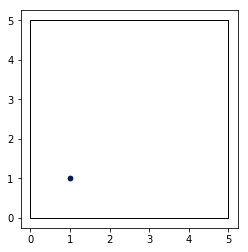

In [167]:
folder_path = "/Users/youssef/Documents/EPFL/Semester_Project/Dataset/GDWN/WGN.wav"
file_to_open = folder_path 
fs , signal = wavfile.read(file_to_open)
#check the content of fs and signal.

room = pra.Room.from_corners(corners,fs=fs)
room.add_source([1,1],signal=signal)

fig , ax = room.plot()



### Microphones

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


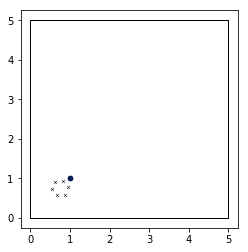

In [168]:
mic = pra.circular_2D_array(center = [.75,.75] , M=6, phi0=0.1, radius=0.2)
#check the meaning of M and phi0
room.add_microphone_array(pra.MicrophoneArray(mic,room.fs))
fig , ax = room.plot()




In [169]:
sf = (0.03*np.sqrt(2)/4)
azimuth = np.array([61.]) / 180. * np.pi
distance = 2.  # meters

### Room impulse responses

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[3.46961924 4.24923941 1.5       ]


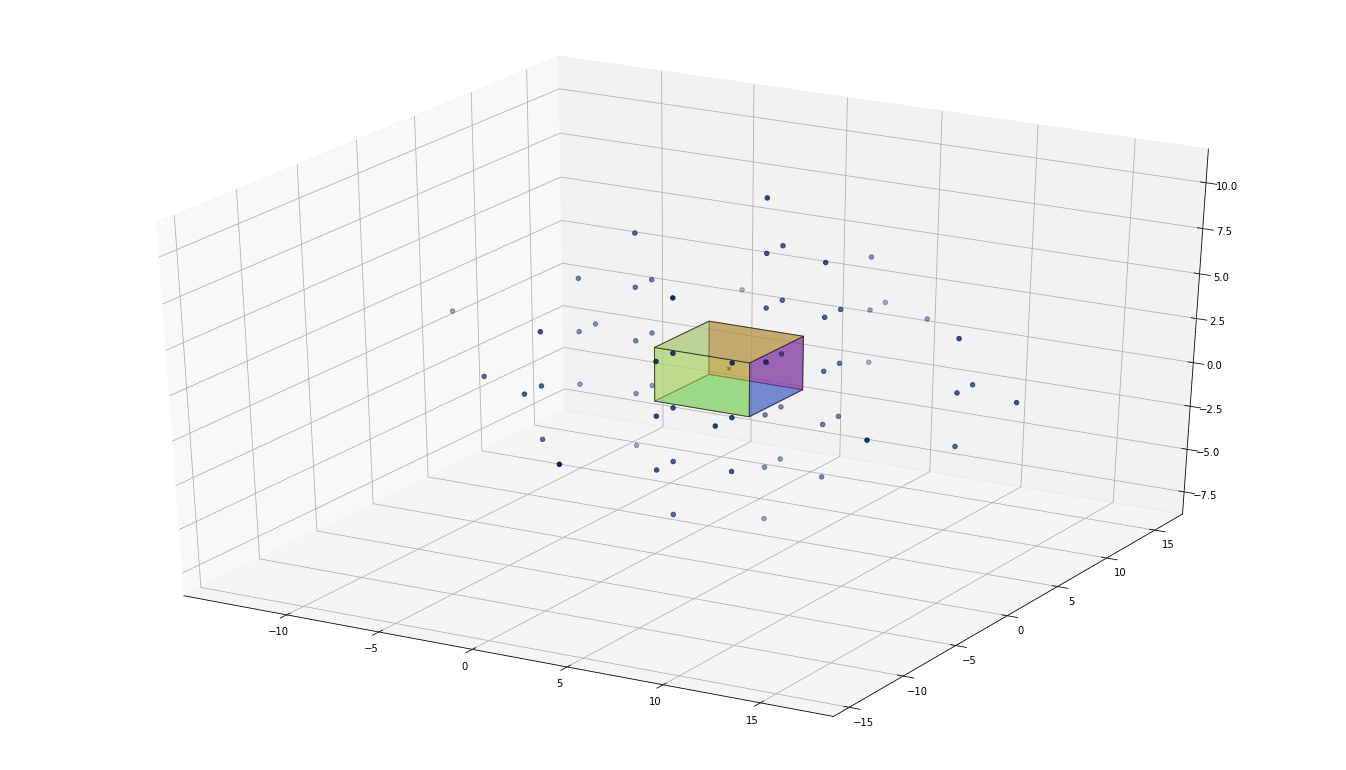

In [170]:
fs,signal = wavfile.read(file_to_open)

sf = (0.03*np.sqrt(2)/4)

room = room.from_corners(corners, fs=fs , max_order=8 ,absorption=absr)
#Understand the specifics of max_orders
room.extrude(3.)

# Add sources of 1 second duration
room_dim = np.array([5,5,3])
rng = np.random.RandomState(23)
duration_samples = int(fs)

for ang in azimuth:
    source_location = room_dim / 2 + (distance * np.array([np.cos(ang), np.sin(ang),0.0]))
    source_signal = rng.randn(duration_samples)
    room.add_source(source_location, signal=signal)
print(source_location) 

#We initiate the point of the Tethra then we scale them
#and translate the origin of the Tethra to the center of the room.
R = np.array([(sf*np.array([1,1,-1,-1]))+2.5,(sf*np.array([1,-1,1,-1]))+2.5,(sf*np.array([1,-1,-1,1]))+1.5])# [[x], [y], [z]]
room.add_microphone_array(pra.MicrophoneArray(R,room.fs))
room.image_source_model(use_libroom=True)

#Visualization
fig, ax = room.plot(img_order=3)
fig.set_size_inches(18.5,10.5)




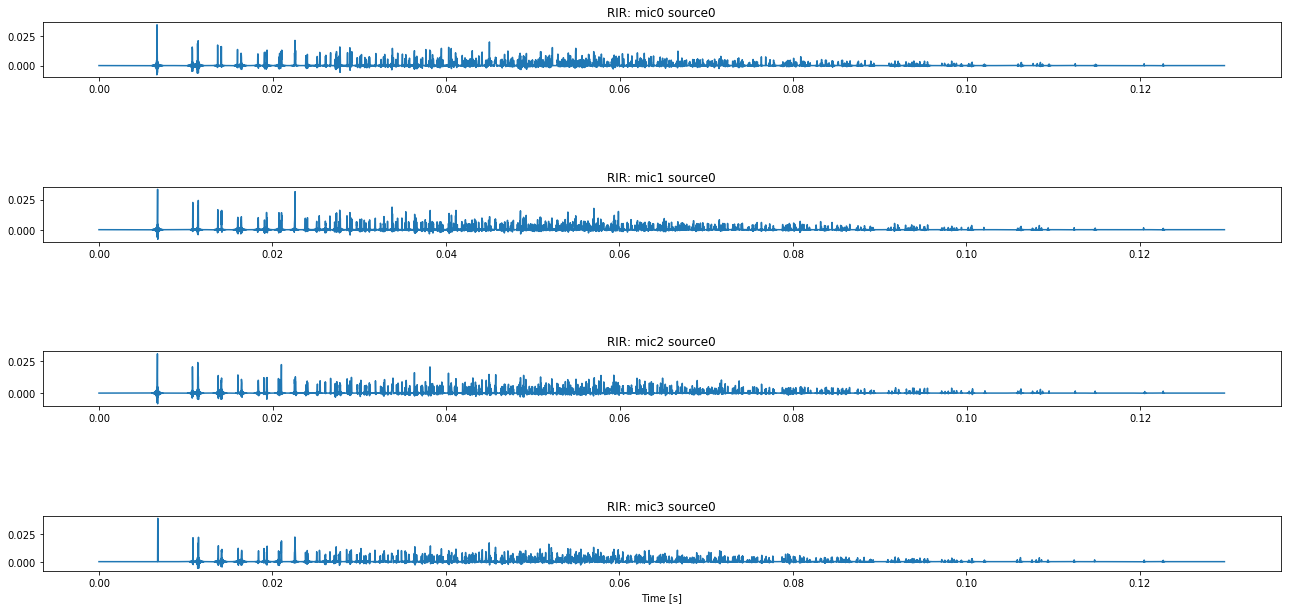

In [171]:
#Plotting the RIR for each microphone
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)
#What is the y axis in theses plots?



In [172]:
#Simulation of the convolved signal with the impulse reponses of each microphone
room.simulate(snr = 5)
print(room.mic_array.signals[0][:])

[ 0.47506006 -0.11180779  0.17210236 ... -0.10007299  0.13192896
 -0.0787138 ]


In [173]:
#We create and audio for the output of our simulation
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [174]:
print("Simulated propagation to 1st mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to 1st mic:


In [175]:
print("Simulated propagation to 2nd mic:")
IPython.display.Audio(room.mic_array.signals[2,:], rate=fs)

Simulated propagation to 2nd mic:


In [176]:
#Noticing no difference between the simulation captured by the first and the second mic ,which normal both mic are very close to each other in this simulation,but very robotic compared to the original WAV

##### Some visualisations for the different signals for a (5x5) room with 2m source-array distance , array = [3.46961924 ,4.24923941 ,1.5 ] , SNR = 5 and RT60 = 0.3.

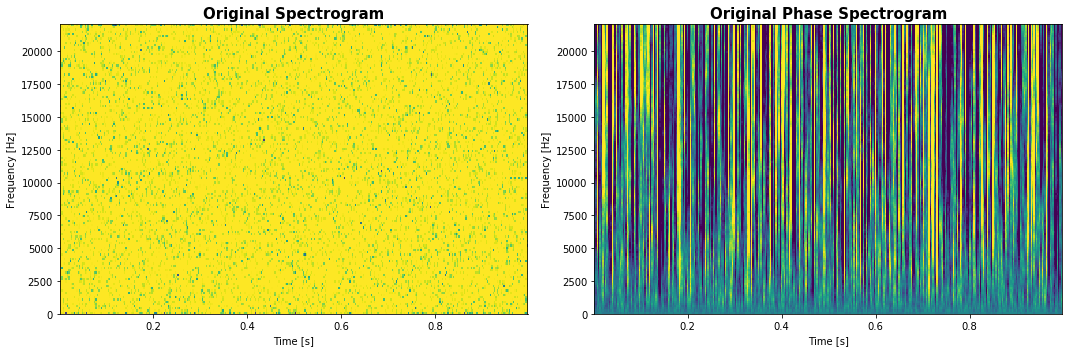

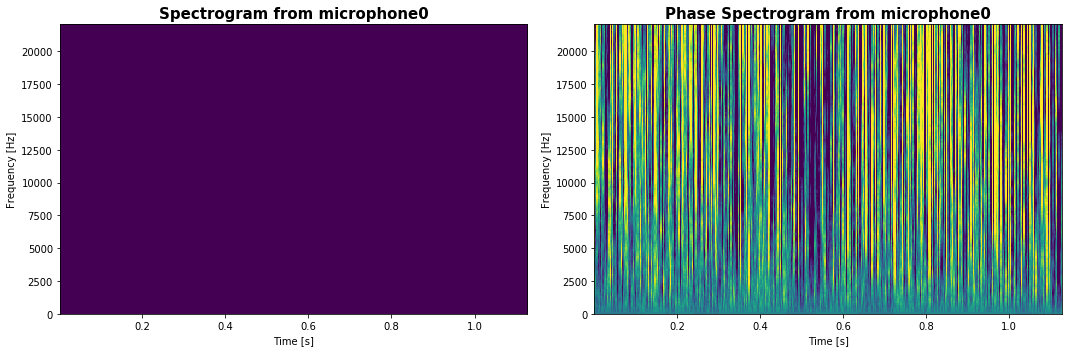

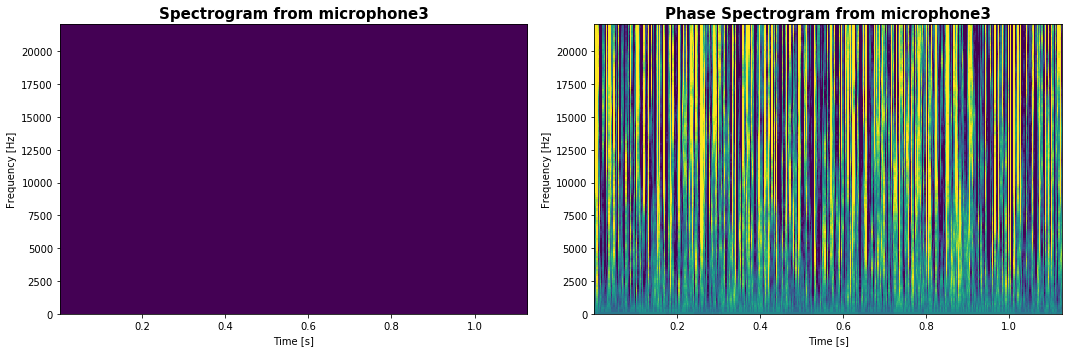

In [177]:
# plot the original signal
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.specgram(signal.astype(np.float32), NFFT=256, Fs=fs, vmin=-20, vmax=30) 
plt.title('Original Spectrogram', fontsize=15, fontweight="bold")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
ax1 = plt.subplot(gs[1])
ax1.specgram(signal.astype(np.float32), NFFT=256, Fs=fs, mode='phase', vmin=-20, vmax=30) 
plt.title('Original Phase Spectrogram', fontsize=15, fontweight="bold")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()


# plot the microphone0 signal
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.specgram(room.mic_array.signals[1,:].astype(np.float32), NFFT=256, Fs=fs, vmin=-20, vmax=30) 
plt.title('Spectrogram from microphone0', fontsize=15, fontweight="bold")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
ax1 = plt.subplot(gs[1])
ax1.specgram(room.mic_array.signals[1,:].astype(np.float32), NFFT=256, Fs=fs, mode='phase', vmin=-20, vmax=30) 
plt.title('Phase Spectrogram from microphone0', fontsize=15, fontweight="bold")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()

# plot the microphone3 signal
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.specgram(room.mic_array.signals[3,:].astype(np.float32), NFFT=256, Fs=fs, vmin=-20, vmax=30) 
plt.title('Spectrogram from microphone3', fontsize=15, fontweight="bold")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
ax1 = plt.subplot(gs[1])
ax1.specgram(room.mic_array.signals[3,:].astype(np.float32), NFFT=256, Fs=fs, mode='phase', vmin=-20, vmax=30) 
plt.title('Phase Spectrogram from microphone3', fontsize=15, fontweight="bold")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()


### Haven't found an answer on why the Spectrogrames generated from the signals captured by the microphones are empy when i set and SNR between [1,10]

In [185]:
matrix = np.empty((4, 129, 391))

In [189]:
for i in range(4):
    f, t, stft_mic0 = signal.stft(room.mic_array.signals[i,:].astype(np.float32), fs)
    spectrum = stft_mic0
    phase = np.angle(spectrum)
    matrix[i] = phase

In [222]:
print(matrix.shape)
type(matrix)

(4, 129, 391)


numpy.ndarray

### Here we store the phase matrix and the audio captured by the microphones of the room in a pickle file so we can use it for our training without need of generating the room.

In [266]:
path = "/Users/youssef/Documents/EPFL/Semester_Project/Dataset/Training_Set/"
i = 0
name_matrix = 'Phase_matrix-{}'.format(i)
fileName_matrix = path + name_matrix
fileObject = open(fileName, 'wb')


In [267]:
save = True 
load = True

In [268]:
if save:
    pkl.dump(matrix, fileObject)
    fileObject.close()


In [269]:
if load:
    fileObject2 = open(fileName, 'rb')
    matrix_loaded = pkl.load(fileObject2)
    fileObject2.close()

if matrix.all() == matrix_loaded.all():
    print(True)
    print(matrix_loaded.shape)

True
(4, 129, 391)


In [270]:
i = 0
name_signals = 'Audio_signals-{}'.format(i)
fileName_signals = path + name_signals
fileObject = open(fileName, 'wb')
pkl.dump(room.mic_array.signals, fileObject)
fileObject.close()


### Here is an example of how the dataset would look like.

In [294]:
dataset = pd.DataFrame(columns = ['Room','Array_position','Distance','RT60','SNR','Audio_file','Phase_Matrix','label'])
#dataset.Roomdim = 4
#dataset.DistanceMic = 2
dataset.Array_position = [source_location]
dataset.RT60 = RT60
dataset.SNR = 5
dataset.Audio_file = fileName_signals
dataset.Phase_Matrix = fileName_matrix
dataset.label = 1
dataset.Room = 5
dataset.Distance = 2
dataset

,Room,Array_position,Distance,RT60,SNR,Audio_file,Phase_Matrix,label
0,5,"[3.4696192404926745, 4.249239414278792, 1.5]",2,0.3,5,/Users/youssef/Documents/EPFL/Semester_Project...,/Users/youssef/Documents/EPFL/Semester_Project...,1
